In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, cheby1, filtfilt, decimate, iircomb, butter, firls, firwin, resample_poly
from scipy import signal
from scipy.io.wavfile import read as wavread
import colorednoise as cn
from statsmodels.regression.linear_model import yule_walker
from numba import njit
from scipy.io.wavfile import write as wavwrite

In [119]:
# =========================================================================
# NÚCLEO DE ALTO RENDIMIENTO (Compilado con Numba)
# =========================================================================
@njit(fastmath=True)
def _core_kalman_loops(y_lp, audio_1, theta_init, Q_param, R_param, Q_sig_base, R_sig, P_theta_init, P_x_init):
    N = len(audio_1)
    
    # --- Pre-alocación de memoria (Crucial para velocidad) ---
    # Para Filtro 1 (Parámetros)
    a1_est = np.zeros(N)
    a2_est = np.zeros(N)
    theta_hat = theta_init.copy()
    P_theta = P_theta_init.copy()
    
    # Para Filtro 2 (Señal) y Smoother
    X_hat_store = np.zeros((N, 2, 1))
    X_pred_store = np.zeros((N, 2, 1))
    P_x_store = np.zeros((N, 2, 2))
    P_pred_store = np.zeros((N, 2, 2))
    A_matrices = np.zeros((N, 2, 2))
    
    # Estado inicial Filtro 2
    X_hat = np.zeros((2, 1))
    P_x = P_x_init.copy()
    
    # Matrices constantes
    I2 = np.eye(2)
    C = np.array([[1.0, 0.0]])  # 1x2
    
    # =====================================================================
    # PASO 2: PRIMER FILTRO DE KALMAN (Parámetros)
    # =====================================================================
    for n in range(2, N):
        # 1. Predicción
        theta_pred = theta_hat
        P_theta_pred = P_theta + Q_param
        
        # 2. Observación H = [y(n-1), y(n-2)]^T
        # Construcción manual para evitar overhead de np.array
        H_n = np.zeros((2, 1))
        H_n[0, 0] = y_lp[n-1]
        H_n[1, 0] = y_lp[n-2]
        
        # 3. Ganancia
        # S = H.T * P * H + R (Escalar)
        PH = np.dot(P_theta_pred, H_n)
        S = np.dot(H_n.T, PH)[0, 0] + R_param
        K = PH / S
        
        # 4. Actualización
        innovation = y_lp[n] - np.dot(H_n.T, theta_pred)[0, 0]
        theta_hat = theta_pred + K * innovation
        
        # P = (I - K*H.T) * P_pred
        KH_T = np.dot(K, H_n.T)
        P_theta = np.dot((I2 - KH_T), P_theta_pred)
        
        # Guardar
        a1_est[n] = theta_hat[0, 0]
        a2_est[n] = theta_hat[1, 0]

    # =====================================================================
    # PASO 3: SEGUNDO FILTRO DE KALMAN (Señal)
    # =====================================================================
    for n in range(2, N):
        # Construir A(n)
        A_n = np.zeros((2, 2))
        A_n[0, 0] = a1_est[n]
        A_n[0, 1] = a2_est[n]
        A_n[1, 0] = 1.0
        A_matrices[n] = A_n
        
        # --- Predicción ---
        X_pred = np.dot(A_n, X_hat)
        P_x_pred = np.dot(np.dot(A_n, P_x), A_n.T) + Q_sig_base
        
        # Guardar (A priori)
        X_pred_store[n] = X_pred
        P_pred_store[n] = P_x_pred
        
        # --- Actualización ---
        y_obs = audio_1[n]
        
        # S = C * P * C.T + R
        PC_T = np.dot(P_x_pred, C.T) # 2x1
        S = np.dot(C, PC_T)[0, 0] + R_sig
        K = PC_T / S
        
        innovation = y_obs - np.dot(C, X_pred)[0, 0]
        X_hat = X_pred + K * innovation
        
        KC = np.dot(K, C) # 2x2
        P_x = np.dot((I2 - KC), P_x_pred)
        
        # Guardar (A posteriori)
        X_hat_store[n] = X_hat
        P_x_store[n] = P_x

    # =====================================================================
    # PASO 4: KALMAN SMOOTHER (RTS)
    # =====================================================================
    X_smooth = np.zeros((N, 2, 1))
    
    # Inicializar el último paso
    X_smooth[N-1] = X_hat_store[N-1]
    
    # Iterar hacia atrás
    for k in range(N - 2, -1, -1):
        P_curr = P_x_store[k]
        A_next = A_matrices[k+1]
        P_pred_next = P_pred_store[k+1]
        
        # Inversa rápida manual 2x2 para velocidad
        # Inv([[a,b],[c,d]]) = 1/(ad-bc) * [[d,-b],[-c,a]]
        a, b = P_pred_next[0, 0], P_pred_next[0, 1]
        c, d = P_pred_next[1, 0], P_pred_next[1, 1]
        det = a*d - b*c
        
        if abs(det) < 1e-12:
            inv_P = np.eye(2) # Fallback seguro
        else:
            inv_P = np.zeros((2, 2))
            inv_P[0, 0] = d
            inv_P[0, 1] = -b
            inv_P[1, 0] = -c
            inv_P[1, 1] = a
            inv_P /= det

        # S = P_k * A.T * P_{k+1|k}^-1
        S_matrix = np.dot(np.dot(P_curr, A_next.T), inv_P)
        
        # x_k^s = x_k + S * (x_{k+1}^s - x_{k+1}^-)
        diff = X_smooth[k+1] - X_pred_store[k+1]
        X_smooth[k] = X_hat_store[k] + np.dot(S_matrix, diff)

    # Extraer señal
    denoised = np.zeros(N)
    for i in range(2, N):
        denoised[i] = X_smooth[i][0, 0]
        
    return denoised

# =========================================================================
# FUNCIÓN ENVOLTORIO (API PÚBLICA)
# =========================================================================
def pcg_kalman_denoising_optimized(audio_1, fs):
    
    """ Versión optimizada con Numba del algoritmo de Nazemi et al. (2021).
    Acelera los bucles de Kalman reduciendo el tiempo de ejecución drásticamente. """
   
    N = len(audio_1)
    
    # 1. Pre-procesamiento (scipy no es compatible con njit, se hace fuera)
    f1, f2 = 20.0, 100.0
    trans = 10.0
    numtaps = 251
    bands = [0.0, f1 - trans - 5, f1 - trans, f1, f2, f2 + trans, f2 + trans + 5, fs / 2.0]
    desired = [0.0, 0.0, 0.0, 5.0, 5.0, 0.0, 0.0, 0.0]
    h = signal.firls(numtaps, bands, desired, fs=fs)
    y_lp = filtfilt(h, 1.0, audio_1)
    
    # 2. Inicialización Yule-Walker (fuera de njit)
    rho, sigma = yule_walker(y_lp[:500], order=2, method="adjusted", demean=True)
    theta_init = np.array([[rho[0]], [rho[1]]])
    
    # 3. Definición de Hiperparámetros
    q_param_std = 1e-2 #1e-4
    r_param_std = 2 #4
    Q_param = np.eye(2) * (q_param_std**2)
    R_param = r_param_std**2
    P_theta_init = np.eye(2) * 1.0
    
    q_sig_std = 1e-3
    r_noise_std = np.std(audio_1[:1000]) * 0.5
    Q_sig_base = np.array([[1.0, 0.0], [0.0, 0.0]]) * (q_sig_std**2)
    R_sig = r_noise_std**2
    P_x_init = np.eye(2) * 0.1
    
    # 4. Llamada al Núcleo Compilado
    # Aseguramos que los arrays sean float64 contiguos para C
    y_lp = np.ascontiguousarray(y_lp, dtype=np.float64)
    audio_1 = np.ascontiguousarray(audio_1, dtype=np.float64)
    
    denoised_signal = _core_kalman_loops(
        y_lp, audio_1, theta_init, 
        Q_param, R_param, Q_sig_base, R_sig, 
        P_theta_init, P_x_init
    )
    
    return denoised_signal

In [130]:
path = 'mediciones_simultaneas/DAVID171225_2.wav'
fs, audio_1 = wavread(path)
audio_1 = audio_1[:,0].astype(np.float32)

# comb filter at w0=50 Hz to remove powerline noise
w0 = 50.0  # Frequency to be removed from signal (Hz)
quality_factor = 30.0  # Quality factor
b_notch, a_notch = iircomb(w0, quality_factor, ftype='notch', fs=fs)

# band-pass filter design cheby1 at 1000 Hz order 3
lowcut = 20.0
highcut = 600.0
b, a = cheby1(3, 0.5, [lowcut, highcut], btype='bandpass', fs=fs)

filtered_signal = filtfilt(b_notch, a_notch, audio_1)
filtered_signal = filtfilt(b, a, filtered_signal)
filtered_signal = decimate(filtered_signal, 48, zero_phase=True)
fs = fs // 48

# segment filtered signal in segments of 1000 samples using np.reshape
num_segments = len(filtered_signal) // 1000
filtered_signal = filtered_signal[:num_segments * 1000]  # Truncate to fit
filtered_signal = filtered_signal.reshape(num_segments, 1000)

# Kalman filtering to denoise filtered signal using numpy.apply_along_axis in each segment
pcg_kalman = np.apply_along_axis(pcg_kalman_denoising_optimized, 1, filtered_signal, fs)
# numpy flip each segment to apply Kalman smoother in reverse
pcg_kalman = np.flip(pcg_kalman, axis=1)
pcg_kalman = np.apply_along_axis(pcg_kalman_denoising_optimized, 1, pcg_kalman, fs)
# flip back to original order
pcg_kalman = np.flip(pcg_kalman, axis=1)
# reshape back to original shape
pcg_kalman = pcg_kalman.reshape(-1)
filtered_signal = filtered_signal.reshape(-1)

b1, a1 = cheby1(8, 0.5, [lowcut, 150], btype='bandpass', fs=fs)
filtered_signal_kalman = filtfilt(b1, a1, pcg_kalman)

# save wav file
wavwrite('mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/david171225_filtered_kalman_2.wav', fs, filtered_signal_kalman.astype(np.float32))

/tmp/ipykernel_17621/3204897580.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio_1 = wavread(path)


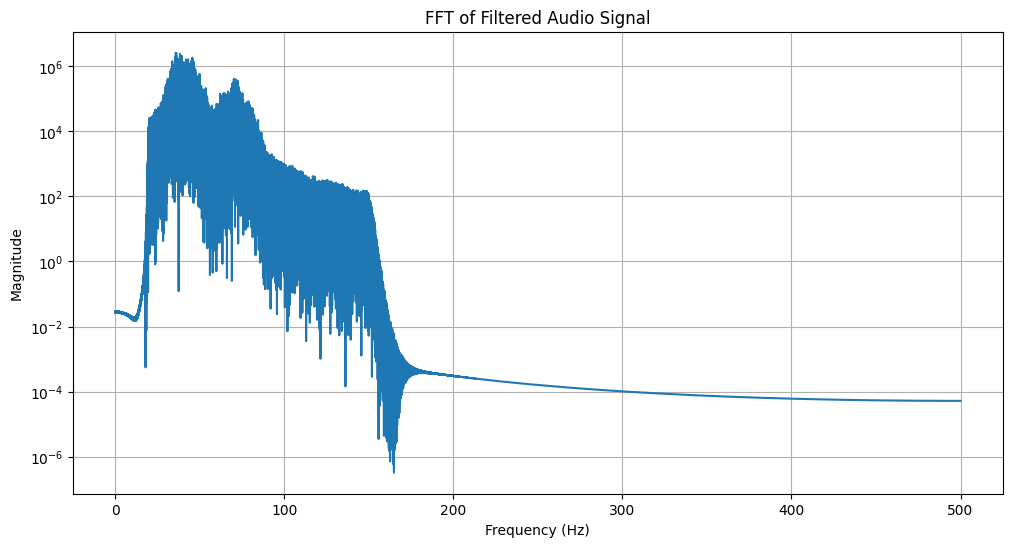

In [131]:
filtered_signal_fft = np.fft.fft(filtered_signal_kalman)
freqs = np.linspace(0, fs/2, len(filtered_signal_fft)//2 + 1)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, np.abs(filtered_signal_fft[:len(filtered_signal_fft)//2 + 1])**2)
plt.title('FFT of Filtered Audio Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
#plt.xlim(0, 500)
plt.show()

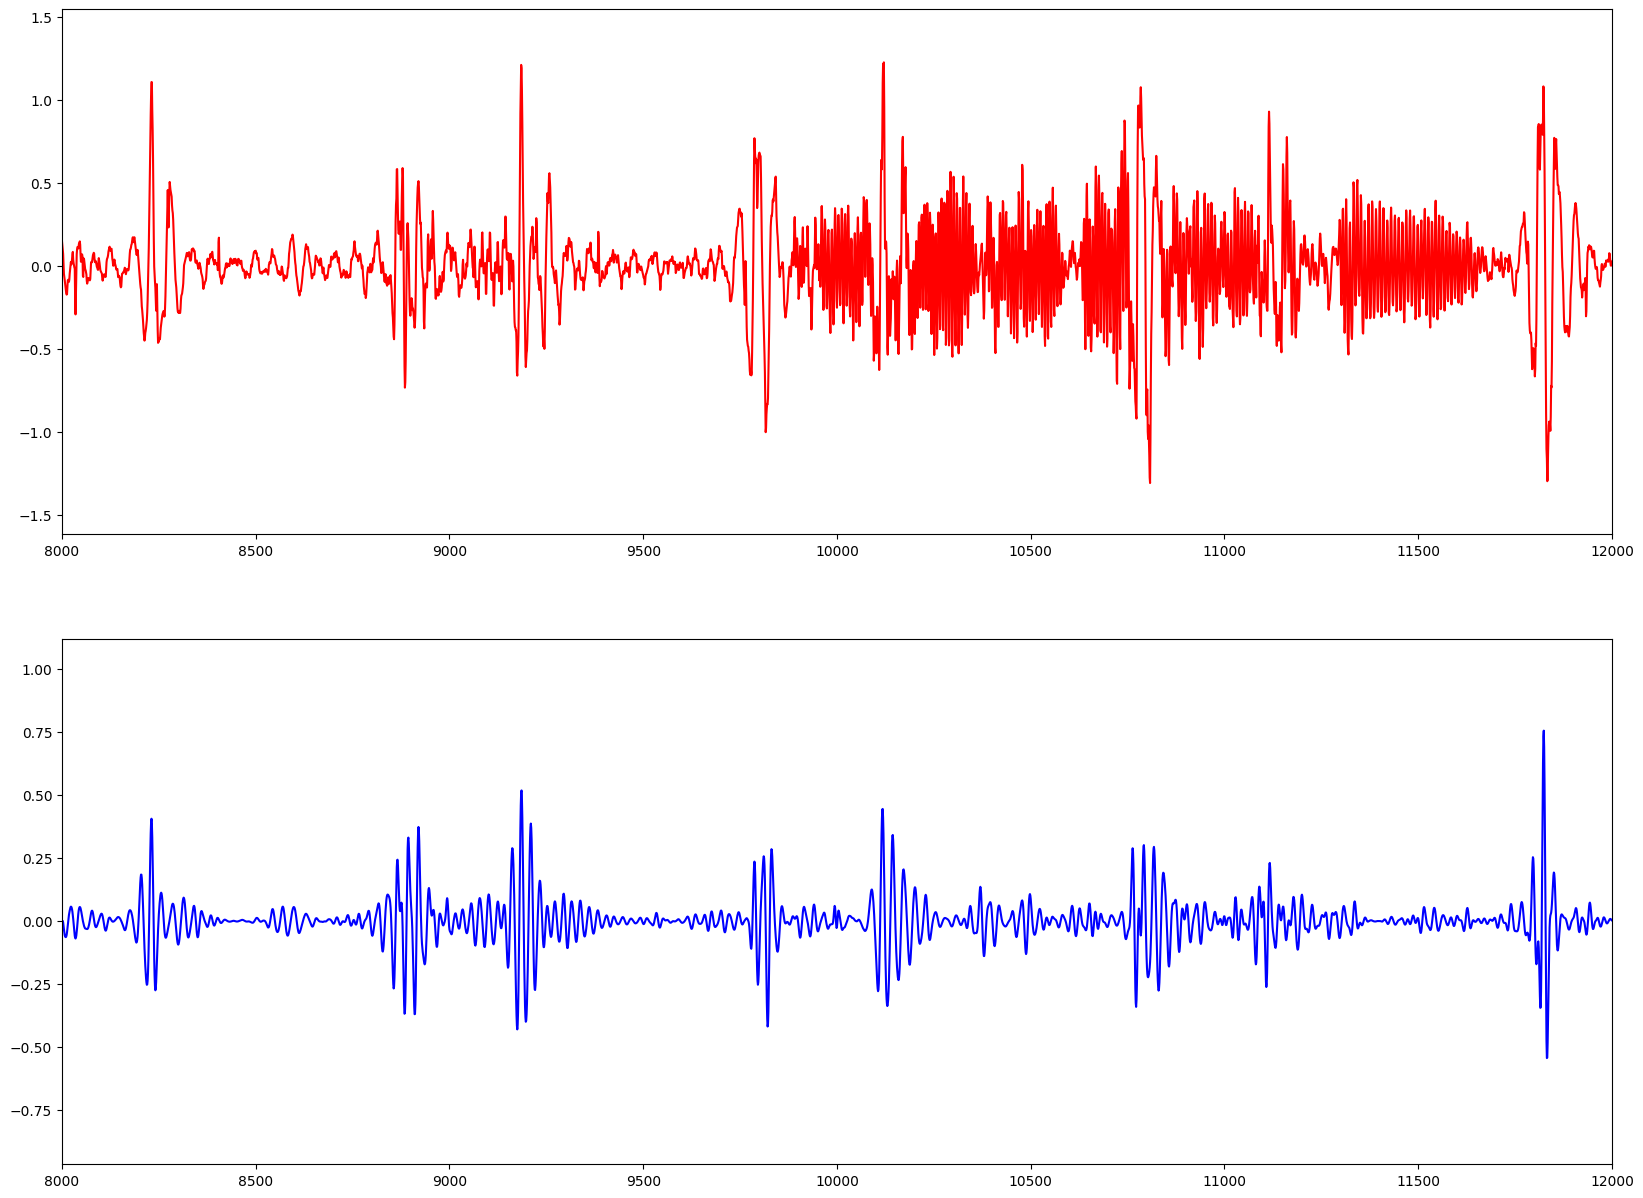

In [134]:
n0 = 0.8e4
n1 = 1.2e4
plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.plot(filtered_signal, color='red', label='Filtered Signal')
plt.xlim(n0, n1)
plt.subplot(2, 1, 2)
plt.plot(filtered_signal_kalman, color='blue', label='Kalman Denoised Signal')
plt.xlim(n0, n1)
plt.show()